# Watson Assistant Quality Analysis

Este notebook demonstra uma forma de avaliar a qualidade de um ChatBot que utiliza IBM Watson Assistant na IBM Cloud. https://github.com/sergiogama/notebook/blob/master/QT-Watson-Assistant.ipynb

O foco é somente avaliação de ML sobre as intenções (Análise avançado consideraria entidades também), e apresenta e discute alguns conceitos de ciência de dados para melhor entendimento.

* **Autor: Renato dos Santos Leal**
* **Colaborador: Sergio Gama (Atualizado Watson Conversation para Watson Assistant API Services)**
* **GitHub: https://github.com/sergiogama/notebook/blob/master/QT-Watson-Assistant.ipynb**
* **Linkedin: https://www.linkedin.com/in/sergiogama/**
* **Youtube: https://www.youtube.clom/c/sergiogama**

## Summary

* [Pré-requisitos](#prereqs)
* [Passo 1 - Bibliotecas neessárias a serem instaladas](#setup)
* [Passo 2 - WCS Credentials](#credentials)
* [Passo 3 - **Anáise exploratória**](#exploratory)
    * [Intent Distribution](#intentdistribution)
    * [Imbalanced Samples and Accuracy Paradox](#adtpa)
    * [Minimum of Examples per Intent](#intentmin)
    * [Repeated Examples](#repeatedexamples)
    * [Log history analysis](#loganalysis)
    * [Overall Mean Confidence](#meanconfidence)
    * [Distribution of log intents and mean confidence by intent](#logdistribution)
    * [Low Confidence Examples](#lowconfidence)
    * [Most Frequent Questions](#manyquestions)
<br/><br/>
* [Step 4 - **Advanced Analysis**](#advanced)
    * [Amostragem](#amostragem)
  

## <a id="prereqs"></a>Pré-requisitos

Para melhor entendimento e uso deste notebook você deve conhecer (Exemplos de cursos e materiais):
* **Python** (https://cognitiveclass.ai/courses/introduction-to-python/)
* **Jupyter Notebooks** (Module 2: https://cognitiveclass.ai/courses/data-science-hands-open-source-tools-2/)
* **ML evaluation metrics (in portuguese)** (Articles 1, 2 e 3: http://bit.ly/2keKqUt)
* **Watson Assistant (in portuguese)** (https://medium.com/as-m%C3%A1quinas-que-pensam/criando-chat-bots-no-facebook-com-o-ibm-watson-351df84e653d)

PS.: Este notebook roda sob Python 3.5 e Spark 2.1

## <a id="setup"></a> Passo 1 - Bibliotecas neessárias a serem instaladas
Instale, importa e atualize as biblioteca conforme necessário

In [1]:
# Update/installs scikit-learn and termcolor 
# !pip install -U scikit-learn
!pip install --upgrade setuptools pip
#!pip install termcolor
#!pip install nbconvert
#!pip install --upgrade notebook
#!pip install --user --upgrade ipywidgets
#!pip install "widgetsnbextension>2.0.0"
#!pip install tensorflow-gpu

#!pip install "tensorflow-tensorboard>=0.1.0"
#!pip uninstall -y widgetsnbextension
!pip install --upgrade "watson-developer-cloud>=2.4.1"

# Supporting Libs
import re
import os
import sys
import json
import time
import nltk
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# Watson APIs Libs
from watson_developer_cloud import AssistantV1

# Metrics & ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Visualization configs
from termcolor import colored, cprint
from IPython.display import display, HTML
%matplotlib inline
matplotlib.style.use('ggplot')
pd.options.display.max_colwidth = 150

Requirement already up-to-date: setuptools in /gpfs/global_fs01/sym_shared/YPProdSpark/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages (40.6.2)
Requirement already up-to-date: pip in /gpfs/global_fs01/sym_shared/YPProdSpark/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages (18.1)
Requirement already up-to-date: watson-developer-cloud>=2.4.1 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages (2.4.1)


## <a id="credentials"></a>Passo 2 - Credenciais do & Funções auxiliares
Para obter suas credenciais do WAS você deve acessar o a tela de API Details no painel de seu Assistant

In [2]:
CTE_WORKSPACE = "ce4785cb-66d7-41e0-83e7-c93424e10a8f"
CTE_API_KEY = "IdJTdBVwQCfZ9XvVvG644o-NMCSl39jR0A6iCO7e9Rir"

assistant = AssistantV1(
    url='https://gateway.watsonplatform.net/assistant/api',
    iam_apikey=CTE_API_KEY,
    version='2018-09-20'
)

original_workspace_id = CTE_WORKSPACE

### Funções auxiliares
Algumas funções para deixar mais fácil de ler: A primeira pega o skill do WAS e checa seu status, a segunda simplesmente imprime no console em vermelho.

In [4]:
# Checa se o skill está pronto para receber chamadas, e se não estiver aguarda 30 segundos e testa novamente. Está função bloqueia o resto do code!
def check_wksp_status(check_workspace_id):
    wksp_notready = True
    
    while(wksp_notready == True):
        print('Testando o workspace...' + check_workspace_id)
        workspace = assistant.get_workspace(workspace_id=check_workspace_id).get_result()

        print('Status do workspace: {0}'.format(workspace['status']))
        if workspace['status'] == 'Available':
            wksp_notready = False
            print('Pronto para uso!')
        else:
            print('Em treinamento...aguarde 30s e tente novamente.')
            time.sleep(30)

# Imprime os logs em vermalho e em negrito
def printred(str_temp,isbold):
    if isbold:
        print(colored(str_temp, 'red', attrs=['bold']))
    else:
        print(colored(str_temp, 'red'))

## <a id="exploratory"></a>Passo 3 - Anáise exploratória

**PS 1:** when working with data science and machine learning it is usually a good practice to have a well-defined methodology in place to guide you through the process of creating your solution. A well-known methodology in market for years is CRISP-DM and it is the one we chose this notebook. 

**PS 2:** if you want to know more about some methodology used in data science project I would recommend this one: https://cognitiveclass.ai/courses/data-science-methodology-2/.

### Intro
An important step of the development of a project using Watson is understanding the data you have and the training you're doing, having a clear understanding of the choices you make during each step will define the success of your project. The techniques presented here will help you with the evaluation stage of CRISP-DM but could be used for data understanding and model training.

The data to be analyzed is divided into two categories:
* **Training data**: the intents, examples and entities of our chatbot
* **Historical data**: user inputs sent to our bot.

To understand the data used in training and interpret it accordingly we'll first do an exploratory analysis based on example quantity and its distribution on each intent, after that we'll focus on an historical analysis with similar techniques.

### Exporting the workspace
Exports all of your chatbot content so we may be able to use it without need to do additional calls to the service.

In [5]:
# It is necessary to use the export flag as True, otherwise only metadata will be returned
original_workspace = assistant.get_workspace(workspace_id=original_workspace_id, export=True)

# Calls the auxiliary function to check if the workspace is ready
check_wksp_status(original_workspace_id)

Testando o workspace...ce4785cb-66d7-41e0-83e7-c93424e10a8f
Status do workspace: Available
Pronto para uso!


### <a id="intentdistribution"></a>Intent Distribution

This is a visual analysis that presents to us how many examples we have in each intent, it helps to understand what kind of questions we're answering and if there is any kind of discrepancy on the size of the training data.

**Questions to have in mind when analyzing the chart:**
* Is there an intent that appears a lot more than others? 
* Why does this happen? 
* Is there an intentn that is too generic? 
* Are our "retraining efforts" focusing on this and forgetting others?

**PS:** by experience when an intent has 3 or 4 times more examples than the others then it usually is too generic. Intent definition approaches will vary a lot depending on the project, using entities will give you more capilarity but even with that you may find yourself with an intent that has 200+ examples.

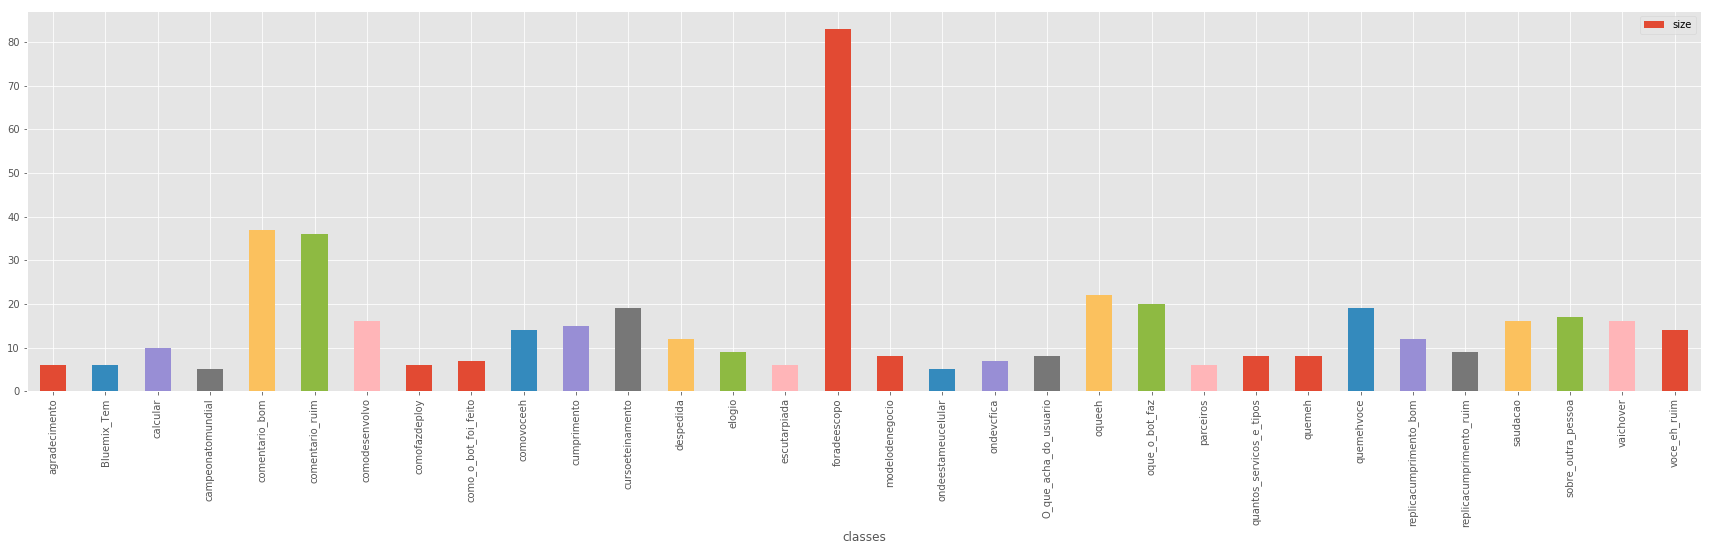

In [34]:
# Get intent list from previous json export
list_original_intents = assistant.list_intents(
    workspace_id = original_workspace_id
).get_result()

list_original_examples = []
list_original_intent_names = []

# Variable declaration
intent_distribution = pd.DataFrame(columns=['classes', 'size'])
avg_size = 0;

# Mounts distribution visualization
for idx, intent in enumerate(list_original_intents['intents']):
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = list_original_intents['intents'][idx]['intent']
    ).get_result()
    avg_size = avg_size + len(examples['examples'])
    for example in examples['examples']:
        list_original_examples.append(example['text'])
        list_original_intent_names.append(list_original_intents['intents'][idx]['intent'])
        intent_distribution.loc[idx] = pd.Series({'classes':list_original_intents['intents'][idx]['intent'], 'size': len(examples['examples'])})
        #avg_size = avg_size + len(examples['examples'])

# Prints the chart on screen
intent_distribution.plot(kind='bar',x='classes', y='size',figsize=(30,7))

# Mounts the data frame
intent_distribution = pd.DataFrame({
    'Example': list_original_examples,
    'Intent': list_original_intent_names
}, columns=['Example','Intent'])

In [35]:
# Average intent size
final_avg_size = avg_size/len(list_original_intents['intents'])

print("Average intent size: " + str(final_avg_size))

Average intent size: 15.0625


### Why concentrating examples into one intent only is not a good idea:
#### <a id="adtpa"></a>Imbalanced Samples and Accuracy Paradox

A common problem we encounter when working with data is related to the fact that the number of occurrences of a given event is, usually, not balanced. In our case people tend to train chatbots without considering the number of examples per intent and then find itself with a bot that has lots of examples for one or two intents and just a little for the rest of it.

In data science we call it an **imbalanced training sample** and its impact on our model quality happens because some distortions are created regarding its udnerstanding. Consider the following:

1. We have a training set with 90 positive examples and 10 negative examples.
2. Your model gets trained with it and assumes that every input should be classified as positive.
3. **Is this a bad model?**
4. **Not necessarily**, your classifier has a 90% accuracy which is quite good!
5. **Is it helpful?** Probably not.

So this is called the **accuracy paradox** (https://en.wikipedia.org/wiki/Accuracy_paradox), having a model that presents good metrics witha training sample but it is not really useful. (You can learn more in here: https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/)

You may also learn something about imbalanced samples and how to treat it with these links:
* https://svds.com/learning-imbalanced-classes/ 
* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

**So, from what we've seen that it is good to keep your training sample with a similar amount of examples!** Let's see how our classifier is doing regarding this.

In [36]:
# Discrepancy coeficient
cte_coef_disc = 0.5

print(colored("\nIntents with a discrepancy of examples (intent # size):\n", attrs=['bold']))

if final_avg_size < 5:
    print(colored(">>> The presented sample does not meet the minimum required for training (5 examples) and therefore the deviations will not be calculated.", 'red', attrs=['bold']))
else:
    # Validação de quais classes estão "ofendendo" a distribuição
    for intent in list_original_intents['intents']:
    #for intent in list_original_intents:
        #print('Inteção: ' + intent['intent'])
        examples = assistant.list_examples(
        workspace_id = original_workspace_id,
        intent = intent['intent']
        ).get_result()

        #print(examples['examples'])
        diff = float(len(examples['examples'])) - final_avg_size
#        diff = float(len(intent['examples'])) - final_avg_size
        if(abs(diff) > (final_avg_size * cte_coef_disc)):
            if diff > 0:
                printred("[+] >>> " + intent['intent'] + ' # ' + str(len(examples['examples'])) + ' / Has ' + str(round(diff-(final_avg_size * cte_coef_disc),2)) + ' more examples than expected.',True)
#                printred("[+] >>> " + intent['intent'] + ' # ' + str(len(intent['examples'])) + ' / Has ' + str(round(diff-(final_avg_size * cte_coef_disc),2)) + ' more examples than expected.',True)
            else:
                printred("[-] >>> " + intent['intent'] + ' # ' + str(len(examples['examples'])) + ' / Has ' + str(round(abs(diff)-(final_avg_size * cte_coef_disc),2)) + ' less examples than expected.',True)
#                printred("[-] >>> " + intent['intent'] + ' # ' + str(len(intent['examples'])) + ' / Has ' + str(round(abs(diff)-(final_avg_size * cte_coef_disc),2)) + ' less examples than expected.',True)
                    


Intents with a discrepancy of examples (intent # size):

[-] >>> agradecimento # 6 / Has 1.53 less examples than expected.
[-] >>> Bluemix_Tem # 6 / Has 1.53 less examples than expected.
[-] >>> campeonatomundial # 5 / Has 2.53 less examples than expected.
[+] >>> comentario_bom # 37 / Has 14.41 more examples than expected.
[+] >>> comentario_ruim # 36 / Has 13.41 more examples than expected.
[-] >>> comofazdeploy # 6 / Has 1.53 less examples than expected.
[-] >>> como_o_bot_foi_feito # 7 / Has 0.53 less examples than expected.
[-] >>> escutarpiada # 6 / Has 1.53 less examples than expected.
[+] >>> foradeescopo # 83 / Has 60.41 more examples than expected.
[-] >>> ondeestameucelular # 5 / Has 2.53 less examples than expected.
[-] >>> ondevcfica # 7 / Has 0.53 less examples than expected.
[-] >>> parceiros # 6 / Has 1.53 less examples than expected.


#### Done! Now we have a first glimpse on which classes to tweak in order to make our classifier more accurate but how can we improve this analysis?

### <a id="intentmin"></a>Minimum examples per intent
Another analysis we may do to guarantee our chatbot best performance is regarding minimum requirements of the API:

Watson Conversation documentation mentions the **need to have at least five examples per intent, but the suggestion is reaching up to ten examples**. Let's check if our chatbot meets those requirements:

In [37]:
print(colored("\nIntents without minimum amount of examples (5):\n", attrs=['bold']))

# Checks if the required minimum has been met
for intent in list_original_intents['intents']:
#for intent in list_original_intents:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ).get_result()

    if len(examples['examples']) < 5:
#    if len(intent['examples']) < 5:
        printred(">>> " + intent['intent'] + ' # ' + str(len(examples['examples'])),True)
        
print(colored("\n\nIntents without minimum SUGGESTED amount of examples (10):\n", attrs=['bold']))

# Checks if the suggested minimum has been met
#for intent in list_original_intents:
for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ).get_result()

    if len(examples['examples']) < 10:
#        printred(">>> " + intent['intent'] + ' # ' + str(len(intent['examples'])),True)
        printred(">>> " + intent['intent'] + ' # ' + str(len(examples['examples'])),True)


Intents without minimum amount of examples (5):



Intents without minimum SUGGESTED amount of examples (10):

>>> agradecimento # 6
>>> Bluemix_Tem # 6
>>> campeonatomundial # 5
>>> comofazdeploy # 6
>>> como_o_bot_foi_feito # 7
>>> elogio # 9
>>> escutarpiada # 6
>>> modelodenegocio # 8
>>> ondeestameucelular # 5
>>> ondevcfica # 7
>>> O_que_acha_do_usuario # 8
>>> parceiros # 6
>>> quantos_servicos_e_tipos # 8
>>> quemeh # 8
>>> replicacumprimento_ruim # 9


** The intents that appear above should be the ones that you must focus first because they dont even meet minimum requirements. You should question the existence of those, are they really necessary? If not, then don't put it in your model, not even if plan to use it in the future.**

### <a id="repeatedexamples"></a>Repeated examples
Our last analysis on intent examples is related to repeated occurrences of it. Although it may not be prohibited, having repeated examples in more than one intent is not a good practice.

In [38]:
print(colored("\nSelects repeated examples in our training set:\n", attrs=['bold']))

# Mounts example frequency
fdist = nltk.FreqDist(intent_distribution['Example'])        

# Select those with more than one occurrence
repeated = [x for idx,x in intent_distribution.sort_values("Example").iterrows() if x['Example'] in [k for k,v in fdist.items() if v > 1]]
for y in repeated:
    print(y['Example'] + ' # ' + y['Intent'])
    
if len(repeated) <= 2:
    print(colored("No repeated examples in our set. Congrats!", 'green'))


Selects repeated examples in our training set:

No repeated examples in our set. Congrats!


## <a id="loganalysis"></a>Log history analysis
Keeping up with our **data understanding** step of the process we will now analyze our chatbot behaviour with real user inputs, the questions sent to our bot in the past.

Let's start by checking intent distribution in our logs just like we've done with our examples.

In [39]:
# Auxiliary function that calls WCS for log output
# Por padrão vai trazer 100 últimas interações
def mount_logs_dump(wid):
    response = assistant.list_logs(
    workspace_id = wid, page_limit = 500
    ).get_result()
    #response = assistant.list_logs(workspace_id = wid,page_limit=500)

    list_mount_examples = []
    list_mount_intents = []
    list_mount_intents2 = []
    list_mount_confidence = []
    list_mount_confidence2 = []
    
    #print(json.dumps(response, indent=2))
    #response_data = json.dumps(response)
    #logs_data = json.dumps(response["logs"])
    #print(response)
        
    cursor_regex = r".*?cursor=(.*?)&"

    #if response and 'logs' in response:
    while response and 'logs' in response:
    
        #print("Step 1")
        #for log in logs_data:
        #for idx, log in enumerate(logs_data):
        cont = 0
        for log in response['logs']:
            cont += 1
            #print("Step 2" + log['response']['input']['text'].strip() + " - " + log['response_timestamp'].strip() + " - Cont: " + str(cont))
            if log["response"]:
#            if 'response' in log:
                lresponse = log['response']
                #print("Step 3")
                
                if 'input' in lresponse and 'text' in lresponse['input']:
                    #print("Step 4")
                    if 'intents' in lresponse and lresponse['intents']:
                        #print("Step 5")
                        list_mount_examples.append(lresponse['input']['text'].strip())
                        list_mount_intents.append(lresponse['intents'][0]['intent'])
                        list_mount_confidence.append(lresponse['intents'][0]['confidence'])

                        if 'alternate_intents' in log['request'] and log['request']['alternate_intents'] == "true":
                            #print("Step 6")
                            list_mount_intents2.append(lresponse['intents'][1]['intent'])
                            list_mount_confidence2.append(lresponse['intents'][1]['confidence'])
                        else:
                            #print("Step 7")
                            list_mount_intents2.append('N/A')
                            list_mount_confidence2.append('0')
                    else:
                        #print("Step 8")
                        list_mount_examples.append(lresponse['input']['text'].strip())
                        list_mount_intents.append('irrelevant')
                        list_mount_confidence.append('0')
                        list_mount_intents2.append('N/A')
                        list_mount_confidence2.append('0')
        
        if 'pagination' not in response or 'next_url' not in response['pagination']:
        #if 'pagination' not in response_data or 'next_url' not in response_data['pagination']:
            break
    
        cursor_res = re.search(cursor_regex, response['pagination']['next_url'], re.IGNORECASE)
        #cursor_res = re.search(cursor_regex, response_data['pagination']['next_url'], re.IGNORECASE)
        cursor = None
    
        if cursor_res:
            cursor = cursor_res.group(1)
        if not cursor:
            break
     
        response = assistant.list_logs(workspace_id=wid, page_limit=1000, cursor=cursor)
    
    df_temp = pd.DataFrame({
        'Example': list_mount_examples,
        'Intent_1': list_mount_intents,
        'Confidence_1': list_mount_confidence,
        'Intent_2': list_mount_intents2,
        'Confidence_2': list_mount_confidence2,
    }, columns=['Example','Intent_1','Confidence_1','Intent_2','Confidence_2'])
    
    return df_temp

In [40]:
# Gather logs from all conversations made to the workspace
list_logs = mount_logs_dump(original_workspace_id)

# Check if there are logs at all
flag_logs = len(list_logs) > 0

In [41]:
# Mounts our data frame for later visualization
if flag_logs:
    dist_logs = pd.DataFrame(columns=['intent', 'sizes','confidencesum'])

    # No need to analyze those
    intent_blacklist = ['greetings','fim']

    for idx,log in list_logs.iterrows():
        if log['Intent_1'] not in intent_blacklist:
            dist_logs.loc[idx] = pd.Series({'intent': log['Intent_1'], 'sizes': 1,'confidencesum': float(log['Confidence_1'])})

### <a id="meanconfidence"></a>Overall Mean Confidence

We could look only at the overall mean confidence of our model regarding user inputs it recieved (and that's an error a lot of people do). **But, as any metric or technique, we should think about what it actuallt represents.**

So let's imagine two different situations:

### Situation 1 - Bad testing distribution
I've got a chatbot with only one well-trained intent and all of the other intents have a really poor training (remmember the imbalanced sample example?). **We should get a bad confidence number, right?** <font color='red'>**Not really.**</font>

* If checked only with our log history and every input was made against the well trained intent then we would have a misleading confidence index with a high number on it. That does not represents reallity of our training.
* **Does this mean our bot is not good enough?** No. It actually responds what it needs most of the time but gets lost with everything else. It does the just, it just isn't that smart.

**When does this usually happens?** We see this type of behaviour when the same team creates and tests the bot. They know what the bot is supposed to answer and are biased to restrict itself within limitations of the training. <font color='red'>**That's why you should test you bot with people that haven't seen it before.**</font>

### Situation 2 - High confidence false positives
**This is somehow more critical because it can lead to image damages to the company if it happens:**

we're talking about false positives, i.e., when your bot returns high confidences for wrong intents/answers. Imagine the same bot as before but with the following result:
* Your users are asking lots of different questions for the remaining intents (not the one with lots of examples) and it always returns that same intent with high confidence (let's just say it assumes that every input belongs to that class and returns with 85% confidence). **Pretty bad huh?**
* Now imagine the intent returned has the "It is always nice talking to you" answer and the user wanted to complain or cancel. Or even worse, the answer comes as something aggressive for someone.


** This is a great example that shows us that using returned confidence without context may give you the opposite effect of the measuring. **

In [42]:
# Calculates overall mean confidence
if flag_logs:
    print("Mean confidence (with irrelevants) > " + str(round(dist_logs['confidencesum'].mean()*100,2)) + " % ")
    print("Mean confidence (without irrelevants) > " + str(round(dist_logs[dist_logs['intent'] != 'irrelevant']['confidencesum'].mean()*100,2)) + " % ")

Mean confidence (with irrelevants) > 79.1 % 
Mean confidence (without irrelevants) > 83.41 % 


**So we have seen that the overall average confidence may not be a good demonstration of the general accuracy level of our bot.**

### <a id="logdistribution"></a>Log Distribution and Mean Confidence by Intent

Now that we discussed what confidence really means and problems it could bring, we can make a smarter analysis of it using two charts:
* Distribution of most asked questions.
* Mean confidence by intent.

With those in hands we may find most asked questions that had lower confidence than expected and prioritize it.

**Good questions would be:**
* Does our main intents reach a minimum level defined by us?
* Which intent should I focus on first?
* For those with less than minimum: do we have enough new inputs to improve retrain accordingly?



Most asked intents with more than 5 examples



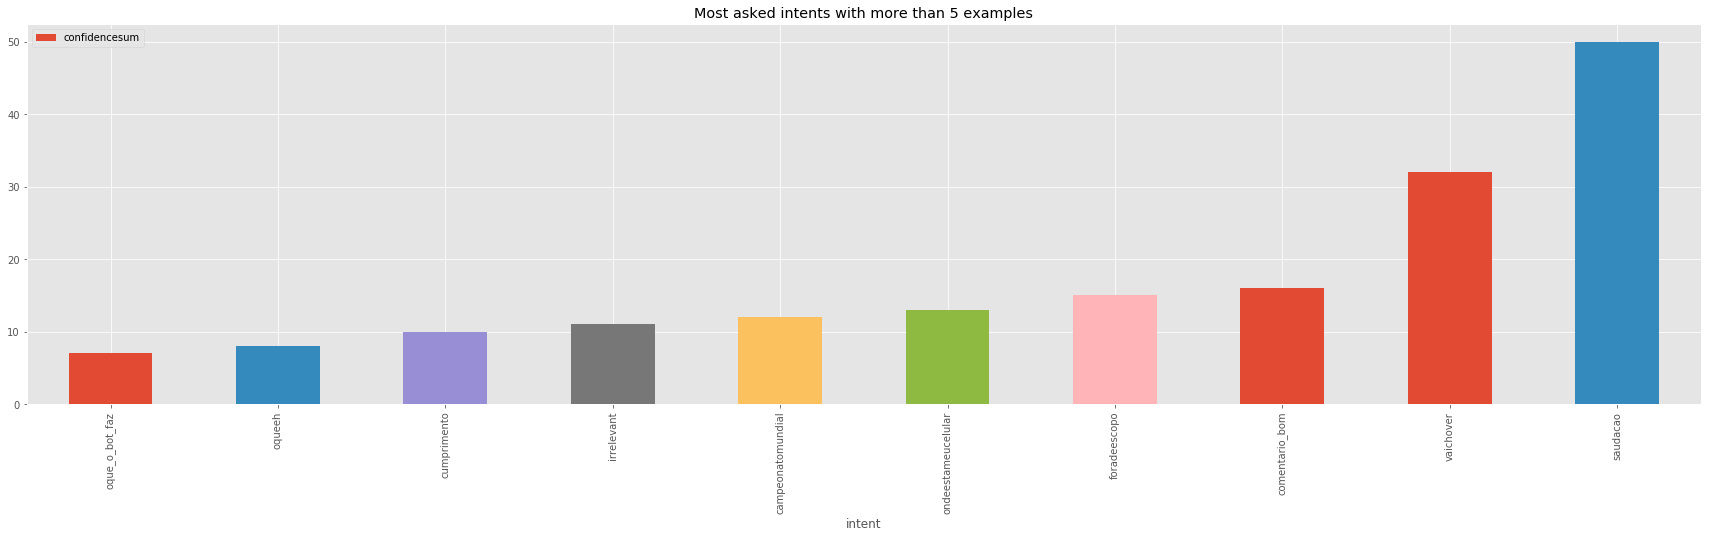

In [43]:
# Groups intents, sum occurences and calculate mean confidence for each.
if flag_logs:
    
    # Groups intents
    grouped1 = dist_logs.groupby('intent').mean()
    grouped2 = dist_logs.groupby('intent').count()
    
    cte_logs = 5

    print(colored('Most asked intents with more than ' + str(cte_logs) + ' examples\n', attrs=['bold']))
    grouped4 = grouped2.where(lambda x : x['sizes'] > cte_logs).dropna().sort_values(by='sizes')
    
    grouped4.index.name='intent'
    grouped4['intent']=grouped4.index
    
    # Shows the distribution log on screen
    grouped4.plot(kind='bar',x='intent', y='confidencesum',figsize=(30,7),title='Most asked intents with more than ' + str(cte_logs) + ' examples')

In [44]:
if flag_logs:
    # Computes the intersection between the series
    df_intersection = pd.merge(grouped4, grouped1, left_index=True, right_index=True)
    df_intersection.drop('confidencesum_x', axis=1, inplace=True)
    
    print(colored('Average confidence by intent (with more than ' + str(cte_logs) + ' examples):\n', attrs=['bold']))
    display(df_intersection.sort_values(by='confidencesum_y'))

Average confidence by intent (with more than 5 examples):



,sizes,intent,confidencesum_y
intent,,,
irrelevant,11.0,irrelevant,0.000000
ondeestameucelular,13.0,ondeestameucelular,0.436310
comentario_bom,16.0,comentario_bom,0.557334
foradeescopo,15.0,foradeescopo,0.691510
oque_o_bot_faz,7.0,oque_o_bot_faz,0.748439
campeonatomundial,12.0,campeonatomundial,0.874505
cumprimento,10.0,cumprimento,0.914825
oqueeh,8.0,oqueeh,0.920161
vaichover,32.0,vaichover,0.953377


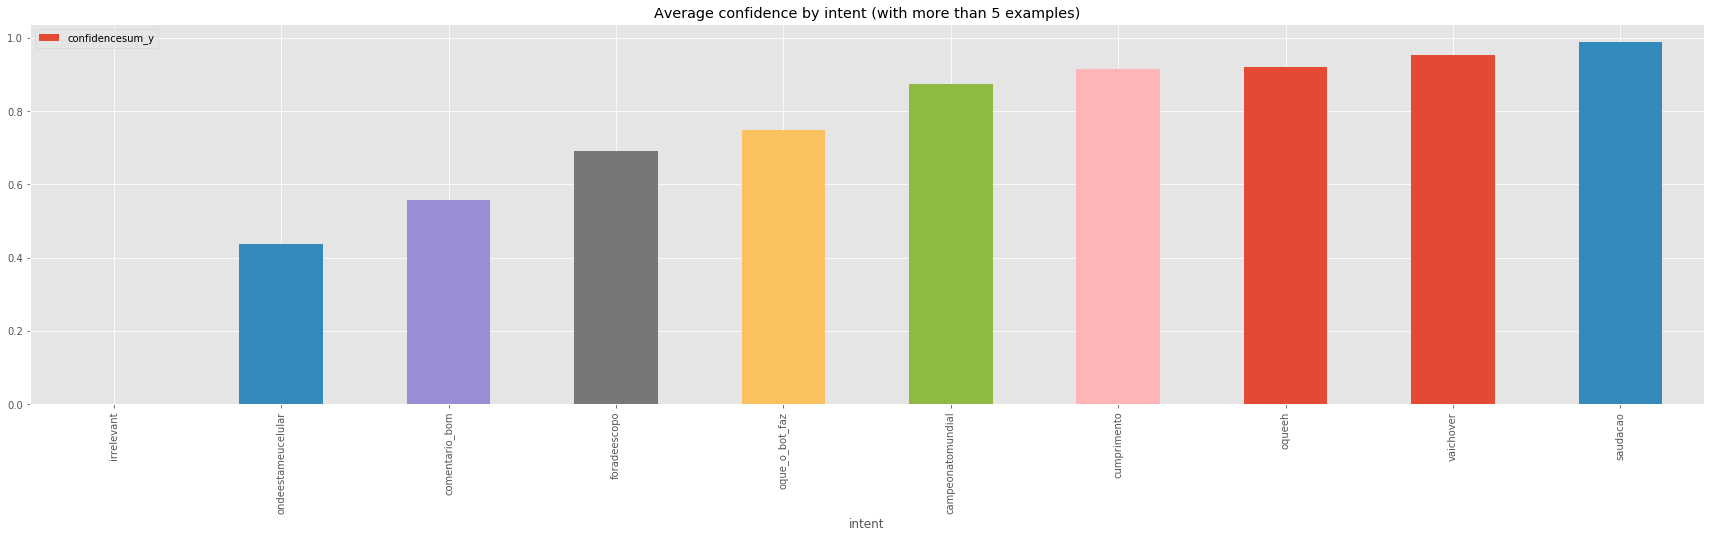

In [45]:
# Prints chart with log distribution vs. overall confidence

if flag_logs:
    df_intersection.sort_values(by='confidencesum_y').plot(kind='bar',x='intent', y='confidencesum_y',figsize=(30,7),title='Average confidence by intent (with more than ' + str(cte_logs) + ' examples)')

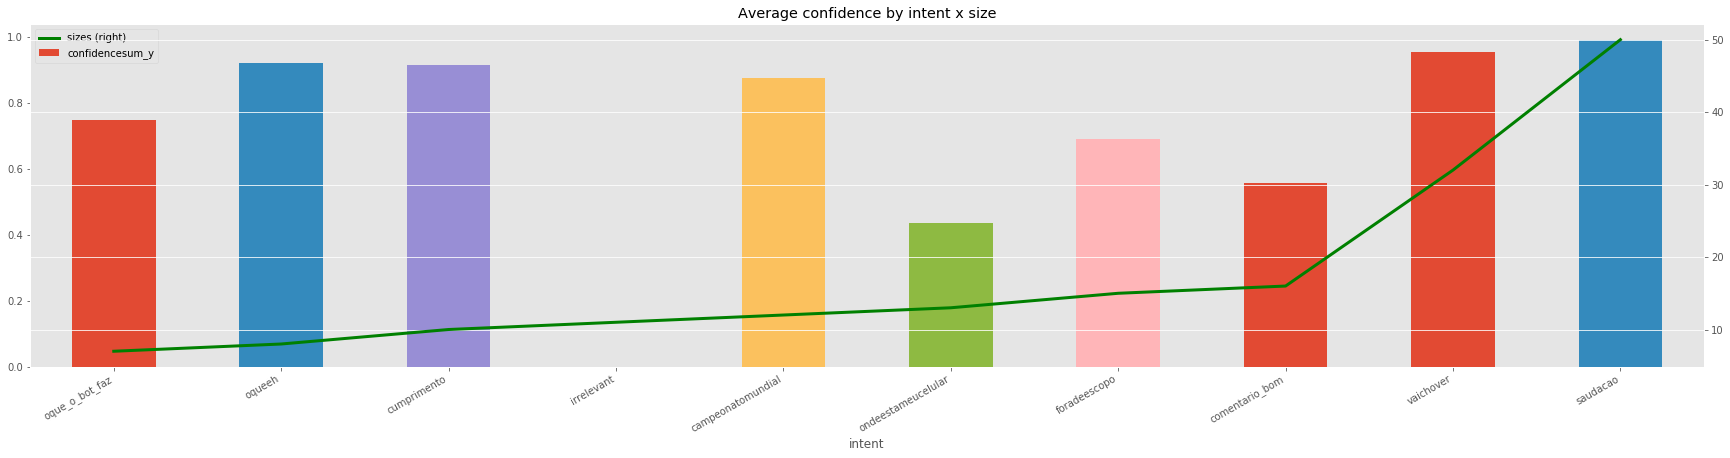

In [46]:
# Prints combined charts
if flag_logs:
    # Removes unnecessary columns
    grouped4.drop('confidencesum', axis=1, inplace=True)
    df_intersection.drop('sizes', axis=1, inplace=True)

    ax = grouped4.plot(kind='line',x='intent', y='sizes',figsize=(30,7),color='g',linewidth=3,secondary_y=True,legend=True)
    df_intersection.plot(ax=ax, kind='bar',x='intent', y='confidencesum_y',figsize=(30,7),title='Average confidence by intent x size',legend=True)
    
    plt.gcf().autofmt_xdate()
    plt.show()

### (Understanding the chart above)
A nice approach here would be defining a minimum threshold for expected confidence and then start analyzing intent by intent from right to left.

### <a id="lowconfidence"></a>Examples with Low Confidence

<font color='red'>[TODO: Translate]</font>


Dependendo da quantidade de interações que o seu bot já teve iniciar um retreino pode parecer uma tarefa assustadora. Uma boa prática é começar o retreino do seu Conversation usando aqueles exemplos que tiveram um nível de confiança muito baixo, essas interações servirão para que você verifique a necessidade de criar novas intenções e/ou adicionar mais exemplos as intenções já existentes, lembrando que estes exemplos trarão mais impacto ao treinamento do que aqueles com alto nível de confiança.

In [47]:
MIN_CONFIDENCE = 0.5

if flag_logs:
    counter = 0
    arr_inputs = []
    arr_intents = []
    arr_confidence = []
    arr_repeated = []

    for idx,log in list_logs.iterrows():
        current_intent = log['Intent_1']

        if current_intent not in intent_blacklist and float(log['Confidence_1']) < MIN_CONFIDENCE:
            arr_repeated.append(log['Example'])

            if float(log['Confidence_1']) < MIN_CONFIDENCE and log['Example'] not in arr_inputs:
                counter = counter + 1
                arr_inputs.append(log['Example'])
                arr_intents.append(log['Intent_1'])
                arr_confidence.append(log['Confidence_1'])
    
    low_confidence = pd.DataFrame({
        'Example': arr_inputs,
        'Intent': arr_intents,
        'Confidence': arr_confidence,
    }, columns=['Example','Intent','Confidence'])

    print(display(arr_inputs[0:20]))

['Onde esta meu iphone',
 'Yes',
 'Se cuide!!',
 'Bluemix realiza verificação de fala?',
 '😉',
 'são bernardo do campo',
 'São Bernardo do campo',
 'Ok',
 'Blue',
 'Pau no seu cú',
 'Você já beijou alguém?',
 'O que é  enconstitucionalicimamente',
 'estou meio cansado',
 'corrupção',
 'Não me mande emojis, eu perdi meu saco',
 'O que sugere?',
 'Qual o seu sexo?',
 'yes',
 '{{watsonMessage}}',
 'bluemix']

None


### <a id="manyquestions"></a>Most Frequent Questions

Another good starting point to retrain your chatbot could be those questions asked more than once without a good confidence level returned.

In [48]:
if flag_logs:
    print(colored("\nSelects those examples with higher occurence (more than 2 repetitions) and lower confidence:\n", attrs=['bold']))

    fdist = nltk.FreqDist(arr_repeated)
    flag = False

    for k,v in sorted(fdist.items(), key=lambda t:t[-1], reverse=True):
        if v > 2:
            flag = True
            print("[" + str(v) + "] > ",k)
    if flag is False:
        print("No repeated logs were found.")


Selects those examples with higher occurence (more than 2 repetitions) and lower confidence:

[13] >  Onde esta meu iphone


## <a id="advanced"></a>Step 4 - Advanced Analysis

<font color='red'>[TODO: Translate]</font>

Para que possamos a analisar a qualidade do nosso chatbot com um pouco mais de profundidade precisamos antes conhecer alguns conceitos:

Primeiro temos que ter em mente que a tarefa de identificar em qual classe (intenção) um input (exemplo) pertence é uma tarefa de classificação estatística (https://en.wikipedia.org/wiki/Statistical_classification) e portanto devemos utilizar métodos específicos para fazer a avaliação deste tipo de tarefa.

Ainda sobre conceitos, considere o problema de verificar se um input pertence a intenção #resetarSenha:
* **True positive (TP)** ou Verdadeiros Positivos (VP): casos em que retornamos a classe correta, o modelo preveu que a classe era #resetarSenha.
* **False positives (FP)** ou Falsos positivos (FP): casos em que retornamos falando que era a classe #resetarSenha quando na verdade era outra.
* **True Negative (TN)** ou Falsos Verdadeiros (FV): casos que retornamos que era outra classe e realmente era.
* **False Negative (FN)** ou Falsos Negativos (FN): retornamos que era outra classe quando na verdade era #resetarSenha.
* **Matriz de Confusão**: traz uma análise visual dos conceitos apresentados acima. 

** Todos esses conceitos são melhores explorados nos seguintes links: **
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chat-bots-inteligentes-introdu-57ff30424192
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chatbots-inteligentes-conceitos-a5b586053973
* https://medium.com/as-m%C3%A1quinas-que-pensam/m%C3%A9tricas-comuns-em-machine-learning-como-analisar-a-qualidade-de-chat-bots-inteligentes-m%C3%A9tricas-1ba580d7cc96

** Obs: por questões de custos vamos fazer uma análise mais simples baseada em amostragem, no fim deste notebook abordaremos outros métodos que podem ser utilizados para medir o seu chatbot com ainda mais precisão. **

In [49]:
# Mounts dataframe to be worked with
le_examples = []
le_intents = []


#for intent in list_original_intents:
for intent in list_original_intents['intents']:
    examples = assistant.list_examples(
    workspace_id = original_workspace_id,
    intent = intent['intent']
    ).get_result()

    for ex in examples['examples']:
#    for ex in intent['examples']:
        le_examples.append(ex['text'])
        le_intents.append(intent['intent'])
        
list_ml_examples = pd.DataFrame({
    'Example': le_examples,
    'Intent': le_intents,
}, columns=['Example','Intent'])

#### <a id="amostragem"></a>Amostragem

<font color='red'>[TODO: Translate]</font>

Como mencionado acima vamos testar nosso bot baseado em amostragem e para isso precisamos separar os datasets entre treino e teste respeitando uma proporção pré-determinada de 80/20, sendo que o conjunto de treino será aquele que efetivamente utilizaremos para treinar um novo modelo e o conjunto de teste nós utilizaremos para submeter ao novo modelo criado e verificar se o resultado é o mesmo que o esperado.

Obs: esse método não funciona tão bem quando temos uma amostra muito pequena pois o modelo treinado terá poucos insumos com o que aprender.

In [50]:
# As we need to submit some examples to test the model this task may generate costs if you have already surpassed the ten thousand free monthly requests.
length_test_set = len(list_ml_examples)*0.2*3

print(colored('ATTENTION! By running this test you might be charged up to ' + str(round(length_test_set*0.00484,2)) + ' reais. Those costs are associated with ' 
              + str(round(length_test_set)) + ' calls to be made to your workspace! Type OK to accept...','red', attrs=['bold']))

acceptance = input()

if acceptance != 'OK':
    print('Ok! Lets continue...')

ATTENTION! By running this test you might be charged up to 1.4 reais. Those costs are associated with 289 calls to be made to your workspace! Type OK to accept...
sim
Ok! Lets continue...


In [51]:
# Auxiliary function that groups intents and mounts an array that WCS can understand. It also validates the number of examples in each intent.
def group_and_mount_intents(train_set):
    
    intents = {}
    
    # Groups intents
    for idx, example in train_set.iterrows():
        current_intent = example['Intent']
        
        if current_intent not in intents: 
            intents[current_intent] = []

        intents[current_intent].append(example['Example'])
        

    workspace_intens = []
    
    # Transform intent format to the one accepted by WCS
    for intent, examples in intents.items():
        entry = {'intent': intent, 'examples': []}
        if len(examples) < 10:
            print("[WARNING] Intent #" + intent + " has fewer examples [" + str(len(examples)) + "] than expected and therefore is not a good example for this test.")

        for example in examples:
            entry['examples'].append({ 'text': example })

        workspace_intens.append(entry)

    print('\nIntents mounted.')

    return workspace_intens

In [52]:
# Auxiliary function that creates a new workspace in order to run tests without damaging the current chatbot
def create_test_workspace(train_set):
    intents_json = group_and_mount_intents(train_set)
    
    entities_list = assistant.list_entities(
        workspace_id = original_workspace_id
    ).get_result()    
    
    #print(entities_list)
    #print("oi")
        
    response = assistant.create_workspace(name = 'Automated_DSX_Test', entities = entities_list['entities'], intents = intents_json, language = 'pt-br')
#    response = assistant.create_workspace(name = 'Automated_DSX_Test', entities = original_workspace['entities'], intents = intents_json, language = 'pt-br')
    print('Workspace criado, aguarde ficar pronto...')
        
    print(response.result["workspace_id"])

    check_wksp_status(response.result["workspace_id"])
            
    return response.result["workspace_id"]

In [53]:
def mount_confusion_matrix(test_set,teste_wid):
    cm_predicted = []
    cm_predicted_2 = []

    cm_conf_p1 = []
    cm_conf_p2 = []
    cm_delta = []

    cm_true = []
    cm_true_q = []
    
    #print(test_set)
    #print("Aqui -> " + teste_wid)

    for index, row in test_set.iterrows():
        message = { 'text': row['Example'] }
        
        response = assistant.message(workspace_id=teste_wid,input=message,alternate_intents=True).get_result()
        #response = assistant.message(workspace_id=teste_wid,message_input=message,alternate_intents=True)

        #print("Aqui 1: msg=" + message['text'])
        #print(response['intents'])
        #print(response.result['intents'])
        
        #if response.result['intents'] != []:
        if response['intents'] != []:
            cm_true_q.append(row['Example'])
            cm_true.append(row['Intent'])
            cm_predicted.append(response['intents'][0]['intent'])
            cm_conf_p1.append(response['intents'][0]['confidence'])
            #print("Aqui 2")

            #if len(response.result['intents']) > 1:            
            if len(response['intents']) > 1:
                cm_predicted_2.append(response['intents'][1]['intent'])
                cm_conf_p2.append(response['intents'][1]['confidence'])
                cm_delta.append(float(response['intents'][0]['confidence']) - float(response['intents'][1]['confidence']))
                #print("Aqui 3")
            else:
                cm_predicted_2.append('irrelevant')
                cm_conf_p2.append(0)
                cm_delta.append(1)
                #print("Aqui 4")
    #print("Aqui 5")
    
    resultados = pd.DataFrame({
        'Question': cm_true_q,
        'True': cm_true,
        'Predicted_1': cm_predicted,
        'Predicted_2': cm_predicted_2,
        'Conf_1': cm_conf_p1,
        'Conf_2': cm_conf_p2,
        'Delta': cm_delta
    }, columns=['Question','True','Predicted_1','Predicted_2','Conf_1','Conf_2','Delta','Missed'])

    resultados['Missed'] = resultados.apply(lambda x : 'X' if x['True'] != x['Predicted_1'] else '', axis=1)
    
    return resultados, cm_true, cm_predicted, cm_predicted_2

In [54]:
def plot_confusion_matrix(cm, classes=None, normalize=False, title='', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## ML Execution Results

As a sampling strategy we run a 80/20 split three times and then calculate resulting scores. If executed only once your results will be unreliable due to the dependency on randomizing sample selection so we do it at least three times to reduce error.

In [55]:
N_ROUNDS = 1
run_wids = []
run_total_df_result = pd.DataFrame(columns=['Question','True','Predicted_1','Predicted_2','Conf_1','Conf_2','Delta','Missed'])
run_total_true = []
run_total_predicted = []
run_total_predicted_2 = []

for run_counter in range(0,N_ROUNDS):
    
    # Splits train and test sets with a 80/20 proportion
    X_train, X_test, y_train, y_test = train_test_split(list_ml_examples, list_ml_examples.Intent, test_size=0.2, stratify=list_ml_examples.Intent)
    
    # Executes test workspace creation
    test_wid = create_test_workspace(X_train)
    
    run_temp_result, run_temp_true, run_temp_predicted, run_temp_predicted_2 = mount_confusion_matrix(X_test,test_wid)
    
    run_wids.append(test_wid)
    run_total_df_result = pd.concat([run_total_df_result,run_temp_result])
    run_total_true = run_total_true + run_temp_true
    run_total_predicted = run_total_predicted + run_temp_predicted
    run_total_predicted_2 = run_total_predicted + run_temp_predicted_2
    
    run_counter = run_counter + 1
    
    # Automatically deletes test workspaces
    assistant.delete_workspace(workspace_id=test_wid)


[WARNING] Intent #modelodenegocio has fewer examples [6] than expected and therefore is not a good example for this test.
[WARNING] Intent #quemeh has fewer examples [6] than expected and therefore is not a good example for this test.
[WARNING] Intent #elogio has fewer examples [7] than expected and therefore is not a good example for this test.
[WARNING] Intent #escutarpiada has fewer examples [5] than expected and therefore is not a good example for this test.
[WARNING] Intent #campeonatomundial has fewer examples [4] than expected and therefore is not a good example for this test.
[WARNING] Intent #comofazdeploy has fewer examples [5] than expected and therefore is not a good example for this test.
[WARNING] Intent #calcular has fewer examples [8] than expected and therefore is not a good example for this test.
[WARNING] Intent #como_o_bot_foi_feito has fewer examples [6] than expected and therefore is not a good example for this test.
[WARNING] Intent #ondeestameucelular has fewer 

In [56]:
class_names = run_total_df_result['True'].drop_duplicates().tolist()
class_names.append('irrelevant')

figure_size = (50,50)
mpl.rcParams['figure.figsize'] = figure_size

### Confusion Matrix

To understand a confusion matrix (cm), you must understand that for each class x:
* True positives: diagonal position, cm(x, x).
* False positives: sum of column x (without main diagonal), sum(cm(:, x))-cm(x, x).
* False negatives: sum of row x (without main diagonal), sum(cm(x, :), 2)-cm(x, x).

Confusion matrix, without normalization


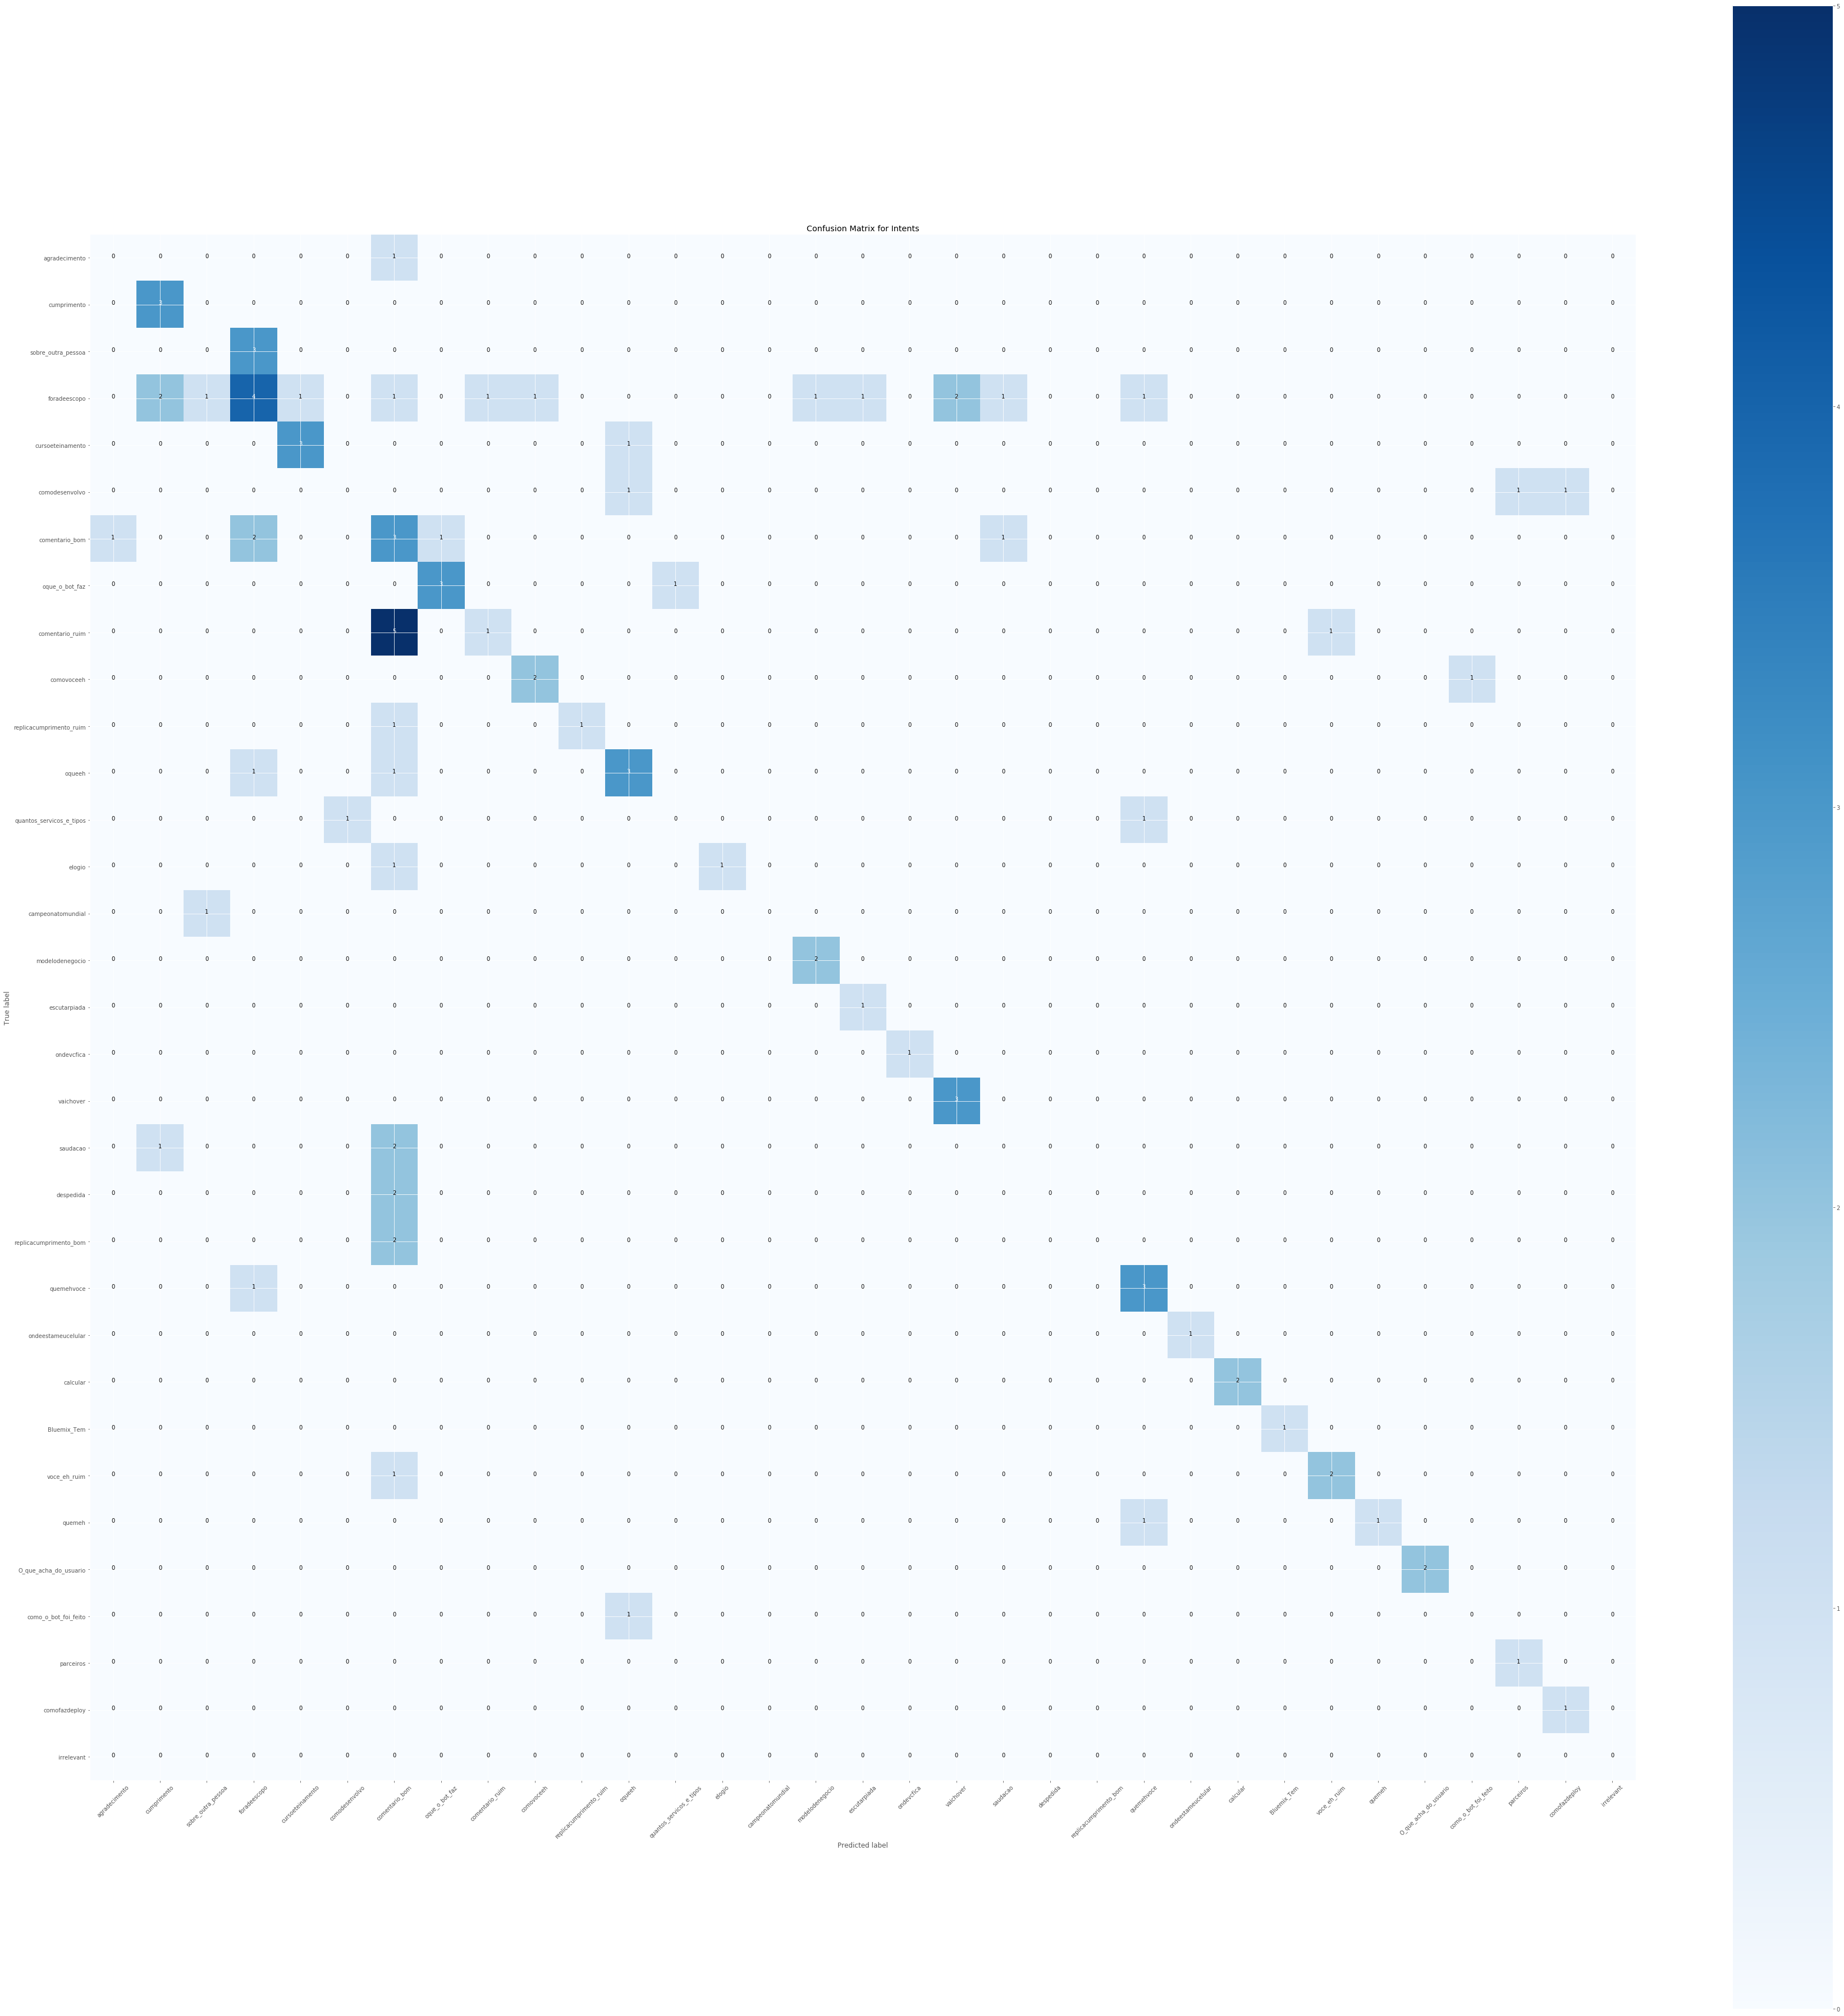

In [57]:
cnf_matrix = confusion_matrix(run_total_true, run_total_predicted, labels=class_names)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix for Intents')

In [58]:
print("Precision")
print("Weighted: " + str(precision_score(run_total_true, run_total_predicted, average='weighted')))

print("\n\nRecall")
print("Weighted: " + str(recall_score(run_total_true, run_total_predicted, average='weighted')))

print("\n\nF1")
print("Weighted: " + str(f1_score(run_total_true, run_total_predicted, average='weighted')))


Precision
Weighted: 0.458919087785


Recall
Weighted: 0.463917525773


F1
Weighted: 0.434064503652


/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
# Metrics for each intent
print(classification_report(run_total_true, run_total_predicted))

                          precision    recall  f1-score   support

             Bluemix_Tem       1.00      1.00      1.00         1
   O_que_acha_do_usuario       1.00      1.00      1.00         2
           agradecimento       0.00      0.00      0.00         1
                calcular       1.00      1.00      1.00         2
       campeonatomundial       0.00      0.00      0.00         1
          comentario_bom       0.15      0.38      0.21         8
         comentario_ruim       0.50      0.14      0.22         7
    como_o_bot_foi_feito       0.00      0.00      0.00         1
          comodesenvolvo       0.00      0.00      0.00         3
           comofazdeploy       0.50      1.00      0.67         1
              comovoceeh       0.67      0.67      0.67         3
             cumprimento       0.50      1.00      0.67         3
        cursoeteinamento       0.75      0.75      0.75         4
               despedida       0.00      0.00      0.00         2
         

/gpfs/fs01/user/scb4-547fcd10f85a8a-6a9412c8378f/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
